In [65]:
import pennylane as qml
import numpy as np
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *
from sklearn.metrics import mean_absolute_error as mse
from sklearn.metrics import r2_score
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer
from scipy.optimize import minimize

# Old autoencoder

In [54]:
# def autoencodert(n_qubit,repetition=2):
#   device = 'default.qubit'
#   dvc=qml.device(device, wires=n_qubit, shots=None)
#   def dense(a,b,parameters):
#       qml.RY(parameters[0],wires=a)
#       qml.RY(parameters[1],wires=b)
#       qml.CNOT(wires=[a,b])
#       qml.RY(parameters[2],wires=a)
#       qml.RY(parameters[3],wires=b)
#       qml.CNOT(wires=[b,a])

#   def pool(a,b,parameters):
#       qml.CRZ(parameters[0],wires=[a,b])
#       qml.X(a)  
#       qml.CRX(parameters[1],wires=[a,b])

#   @qml.qnode(dvc,interface='jax', diff_method=None)
#   def cirq(param):
#     start=0
#     for i in range(repetition):
#       if start % 2!=0:
#         raise Exception('The number of qubits should be a power of 2 greater than 2 to the power of repetition')

#       for a in range(start,( n_qubit-start)//2+start):
#           param_corrente=sum([6*n_qubit//2**(i+1) for i in range(i)])+a*6
#           dense(a,a+(n_qubit-start)//2,param[param_corrente:param_corrente+4])
#           pool(a,a+(n_qubit-start)//2,param[param_corrente+4:param_corrente+6])
#       start+=n_qubit//(2**(i+1))
#       qml.Barrier(dvc.wires)

#     return qml
#   return cirq,n_qubit-n_qubit//(2**(repetition))

# repetition=4
# num_params=sum([6*n_qubit//2**(i+1) for i in range(repetition)])
# cirq,trash=autoencodert(4)
# fig, ax = qml.draw_mpl(cirq)([1]*num_params)
# plt.show()



# Train autoencoder


### Trying to use the datasets from pennylanes

In [56]:
# qml.data.list_attributes('qspin')
# qml.data.list_datasets()['qspin']['Ising']
# df =qml.data.load('qspin',sysname='Ising')[0]
# print(type(df))
# df.attr_info
# type(df.hamiltonians[0])


# device = 'default.qubit'
# dvc=qml.device(device, wires=len(df.hamiltonians[0].wires), shots=None)

# @qml.qnode(dvc,interface='jax', diff_method=None)
# def useit():
#     return qml.expval(df.hamiltonians[0])
# fig, ax = qml.draw_mpl(useit)()


## simple dataset

In [70]:
def train():
    r2 = []
    loss = []   
    n_qubit_autoencoder=8
    repetition=1
    n_qubit_swap=n_qubit_autoencoder-n_qubit_autoencoder//(2**(repetition))
    n_qubit=n_qubit_autoencoder+n_qubit_swap
    num_params=sum([6*n_qubit_autoencoder//2**(i+1) for i in range(repetition)])
    epochs= 50
    device = 'default.qubit'
    dvc=qml.device(device, wires=n_qubit, shots=None)

    @qml.qnode(dvc,interface='jax', diff_method=None)
    def trainer(param,p):
        create_isotropic_state(p, n_qubit_autoencoder, n_qubit_swap)()
        qml.Barrier(dvc.wires)
        autoencoder(n_qubit_swap,param,repetition,n_qubit_autoencoder)
        qml.Barrier(dvc.wires)
        destructive_swap(n_qubit_swap)
        return qml.probs(list(range(n_qubit_swap*2)))

    n= 67
    P=np.random.rand(n)
    np.random.shuffle(P)
    y=[0]*n
    import random 
    random.seed(42)
    weights=[random.uniform(0, 1) for _ in range(n)]

    def loss_function(w): 
        pred =[interpret_results(trainer(w,x)) for x in P]
        r2.append(r2_score(y,pred))
        loss.append(mse(pred,y))
        print(f'\r{r2[-1]}')
        return mse(pred,y)



    for _ in range(epochs):
        res=minimize(loss_function,weights,method='COBYLA',options={'maxiter':23})

    plt.plot(r2)
    plt.show()
    plt.plot(loss)
    plt.show()
    print(res)
    # weights,_,_,_,_= opt.step(loss_function, weights,trainer, n_qubit ,P, y)


In [71]:
train()

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


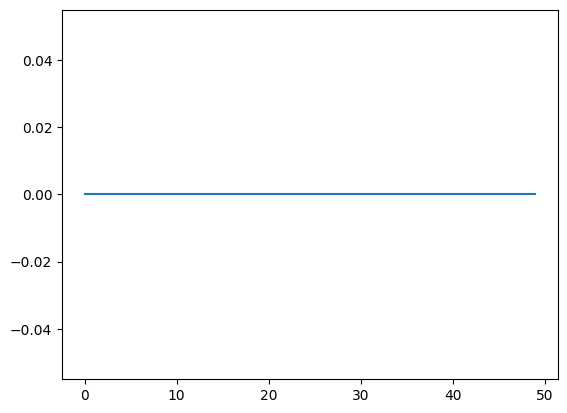

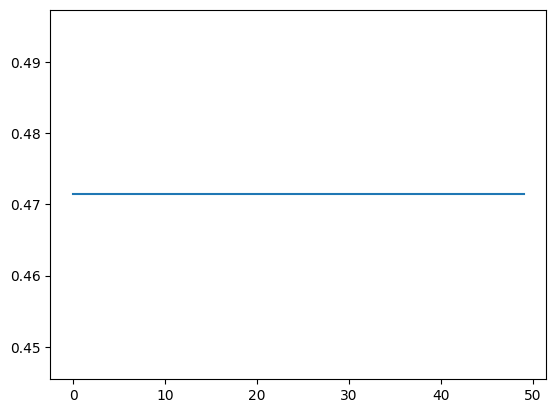